# Feature Selection for log_diff_model (Multivariate Model)

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from bdi_predict.ml_logic.sequence_gen import WindowGenerator
from tensorflow.keras import layers
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
bdi = pd.read_csv("../raw_data/data/BDI/log_diff_BDI_daily.csv")
bdi.head(2)

,Unnamed: 0,Date,Price,abs_price,log_price,log_diff
0,0,1995-01-03,1964.0,NaN,3.293141,NaN
1,1,1995-01-04,1961.0,-3.0,3.292478,-0.000664


In [3]:
bdi["Date"] = pd.to_datetime(bdi["Date"])
bdi.set_index("Date", inplace=True)
bdi= bdi[bdi.index != "1995-01-03"]
bdi.drop(columns="Unnamed: 0", inplace=True)
bdi.head(2)

,Price,abs_price,log_price,log_diff
Date,,,,
1995-01-04,1961.0,-3.0,3.292478,-0.000664
1995-01-05,1967.0,6.0,3.293804,0.001327


In [26]:
feat = pd.read_csv("../raw_data/data/merged_features.csv")
feat["Date"] = pd.to_datetime(feat["Date"])
feat.set_index("Date", inplace=True)
feat.drop(columns="Unnamed: 0", inplace=True)
feat = feat[["equally weighted"]]
feat.rename(columns={"equally weighted":"GHP"}, inplace=True)
GHP=feat
GHP

,GHP
Date,
1995-01-03,100.117367
1995-01-04,100.117367
1995-01-05,100.117367
1995-01-06,100.117367
1995-01-09,100.117367
...,...
2022-11-08,107.030433
2022-11-09,106.747531
2022-11-10,106.464629


In [27]:
df = pd.merge(bdi, GHP, on="Date", how="inner")
#df.drop(columns="Price_y", inplace=True)


In [28]:
df.head(3)

,Price,abs_price,log_price,log_diff,GHP
Date,,,,,
1995-01-04,1961.0,-3.0,3.292478,-0.000664,100.117367
1995-01-05,1967.0,6.0,3.293804,0.001327,100.117367
1995-01-06,1983.0,16.0,3.297323,0.003518,100.117367


# Data Cleaning

## Holdout Method (manual, chronological)

In [29]:
input_length = len(df)

In [30]:
def train_test_split(df:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> tuple:
    '''
    Returns a train dataframe and a test dataframe (df_train, df_test)
    from which one can sample (X,y) sequences using TimeseriesGenerator.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    
    # TRAIN SET

    last_train_idx = round(train_test_ratio * len(df))
    df_train = df.iloc[0:last_train_idx, :]

    # TEST SET
 
    first_test_idx = last_train_idx - input_length
    df_test = df.iloc[first_test_idx:, :]

    return (df_train, df_test)

In [31]:
df_train, df_test = train_test_split(df=df, train_test_ratio=0.8, input_length=input_length)

In [32]:
X_train = df_train[["Price","GHP"]]
y_train = df_train["log_diff"]

X_test  = df_test[["Price","GHP"]]
y_test = df_test["log_diff"]

In [33]:
#Feature Scaling

scaler_X = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.fit_transform(X_test)



In [34]:
generator = TimeseriesGenerator(X_train_scaled, y_train, length=20, batch_size=8, sampling_rate=1, stride=1)

In [35]:
len(generator)

704

In [36]:
generator_val = TimeseriesGenerator(X_test_scaled, y_test, length=20, batch_size=8, sampling_rate=1, stride=1)

In [37]:
for X, y in generator:
    print(X.shape, y.shape)
    print(X[0], y[0])
    #listy = [float(X[0][i]) for i in range(len(X[0]))]
    #print(listy)
    break

(8, 20, 2) (8,)
[[0.14519214 0.00564203]
 [0.14571379 0.00564203]
 [0.14710485 0.00564203]
 [0.14806121 0.00564203]
 [0.14988698 0.00564203]
 [0.15023474 0.00564203]
 [0.15188663 0.00564203]
 [0.15379934 0.00564203]
 [0.15440793 0.00564203]
 [0.15475569 0.00564203]
 [0.15475569 0.00564203]
 [0.15466875 0.00564203]
 [0.1537124  0.00564203]
 [0.15240828 0.00564203]
 [0.15136498 0.00564203]
 [0.1501478  0.00564203]
 [0.14823509 0.00564203]
 [0.14710485 0.00564203]
 [0.1465832  0.00564203]
 [0.14623544 0.00564203]] -0.0015435717560743


# The Model

In [38]:
# Learning Rate Scheduler: 

lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

In [39]:
#Optimizers

rmsprop = RMSprop(learning_rate=lr_schedule) #or 0.001 for inital test
adam = Adam(learning_rate=lr_schedule)

In [40]:
#Early Stopping Criterion:

es = EarlyStopping(monitor="val_mae", patience=100, restore_best_weights=True)

In [41]:
#Initializing and compiling model:

def init_model():
    
    model = Sequential()

    #LSTM layers
    model.add(layers.LSTM(60, activation="tanh", input_shape=(20,2), return_sequences=False))

    #Dense layers
    model.add(layers.Dense(100, activation="relu"))
    model.add(layers.Dense(1, activation="linear"))

    #compiling model
    model.compile(loss="mse", optimizer=rmsprop, metrics="mae")
    
    return model

# Training and Testing

In [42]:
#Instantiating model

model = init_model()

In [43]:
#Model layers & params overview:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 60)                15120     
                                                                 
 dense_2 (Dense)             (None, 100)               6100      
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 21,321
Trainable params: 21,321
Non-trainable params: 0
_________________________________________________________________


In [44]:
#TRAINING THE MODEL:

history = model.fit(
    generator, epochs=1000, validation_data=generator_val, shuffle=True, callbacks=es
)

Epoch 1/1000
704/704 [==============================] - 3s 3ms/step - loss: 1.8795e-04 - mae: 0.0095 - val_loss: 1.0413e-04 - val_mae: 0.0077
Epoch 2/1000
704/704 [==============================] - 2s 2ms/step - loss: 7.8000e-05 - mae: 0.0062 - val_loss: 1.0229e-04 - val_mae: 0.0076
Epoch 3/1000
704/704 [==============================] - 2s 2ms/step - loss: 6.9228e-05 - mae: 0.0057 - val_loss: 1.1758e-04 - val_mae: 0.0083
Epoch 4/1000
704/704 [==============================] - 2s 2ms/step - loss: 6.2413e-05 - mae: 0.0054 - val_loss: 1.0582e-04 - val_mae: 0.0078
Epoch 5/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.9532e-05 - mae: 0.0053 - val_loss: 1.0399e-04 - val_mae: 0.0077
Epoch 6/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.9745e-05 - mae: 0.0053 - val_loss: 1.0328e-04 - val_mae: 0.0077
Epoch 7/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.8781e-05 - mae: 0.0052 - val_loss: 1.0279e-04 - val_mae: 0.0076
Epoch 

704/704 [==============================] - 2s 2ms/step - loss: 5.7417e-05 - mae: 0.0052 - val_loss: 1.0207e-04 - val_mae: 0.0077
Epoch 59/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.7443e-05 - mae: 0.0051 - val_loss: 1.0271e-04 - val_mae: 0.0076
Epoch 60/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.7367e-05 - mae: 0.0051 - val_loss: 1.0247e-04 - val_mae: 0.0076
Epoch 61/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.6788e-05 - mae: 0.0051 - val_loss: 1.0440e-04 - val_mae: 0.0078
Epoch 62/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.6991e-05 - mae: 0.0051 - val_loss: 1.0731e-04 - val_mae: 0.0078
Epoch 63/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.7662e-05 - mae: 0.0051 - val_loss: 1.0205e-04 - val_mae: 0.0077
Epoch 64/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.7250e-05 - mae: 0.0051 - val_loss: 1.0202e-04 - val_mae: 0.0076
Epoch 65/1000

704/704 [==============================] - 2s 2ms/step - loss: 5.6630e-05 - mae: 0.0051 - val_loss: 1.0268e-04 - val_mae: 0.0076
Epoch 116/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.6895e-05 - mae: 0.0051 - val_loss: 1.0321e-04 - val_mae: 0.0077
Epoch 117/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.6776e-05 - mae: 0.0051 - val_loss: 1.0207e-04 - val_mae: 0.0076
Epoch 118/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.7171e-05 - mae: 0.0051 - val_loss: 1.0219e-04 - val_mae: 0.0077
Epoch 119/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.7148e-05 - mae: 0.0051 - val_loss: 1.0201e-04 - val_mae: 0.0076
Epoch 120/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.6782e-05 - mae: 0.0051 - val_loss: 1.0252e-04 - val_mae: 0.0076
Epoch 121/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.7009e-05 - mae: 0.0051 - val_loss: 1.0222e-04 - val_mae: 0.0077
Epoch 1

Epoch 172/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.6524e-05 - mae: 0.0051 - val_loss: 1.0207e-04 - val_mae: 0.0077
Epoch 173/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.6644e-05 - mae: 0.0050 - val_loss: 1.0378e-04 - val_mae: 0.0078
Epoch 174/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.6462e-05 - mae: 0.0050 - val_loss: 1.0243e-04 - val_mae: 0.0077
Epoch 175/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.6680e-05 - mae: 0.0050 - val_loss: 1.0217e-04 - val_mae: 0.0077
Epoch 176/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.6399e-05 - mae: 0.0050 - val_loss: 1.0241e-04 - val_mae: 0.0077
Epoch 177/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.6715e-05 - mae: 0.0050 - val_loss: 1.0199e-04 - val_mae: 0.0076
Epoch 178/1000
704/704 [==============================] - 2s 2ms/step - loss: 5.5876e-05 - mae: 0.0050 - val_loss: 1.0338e-04 - val_mae:

In [45]:
model.evaluate(generator_val)

175/175 [==============================] - 0s 626us/step - loss: 1.0218e-04 - mae: 0.0076


[0.00010218317765975371, 0.007631364744156599]

array([<AxesSubplot: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <AxesSubplot: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

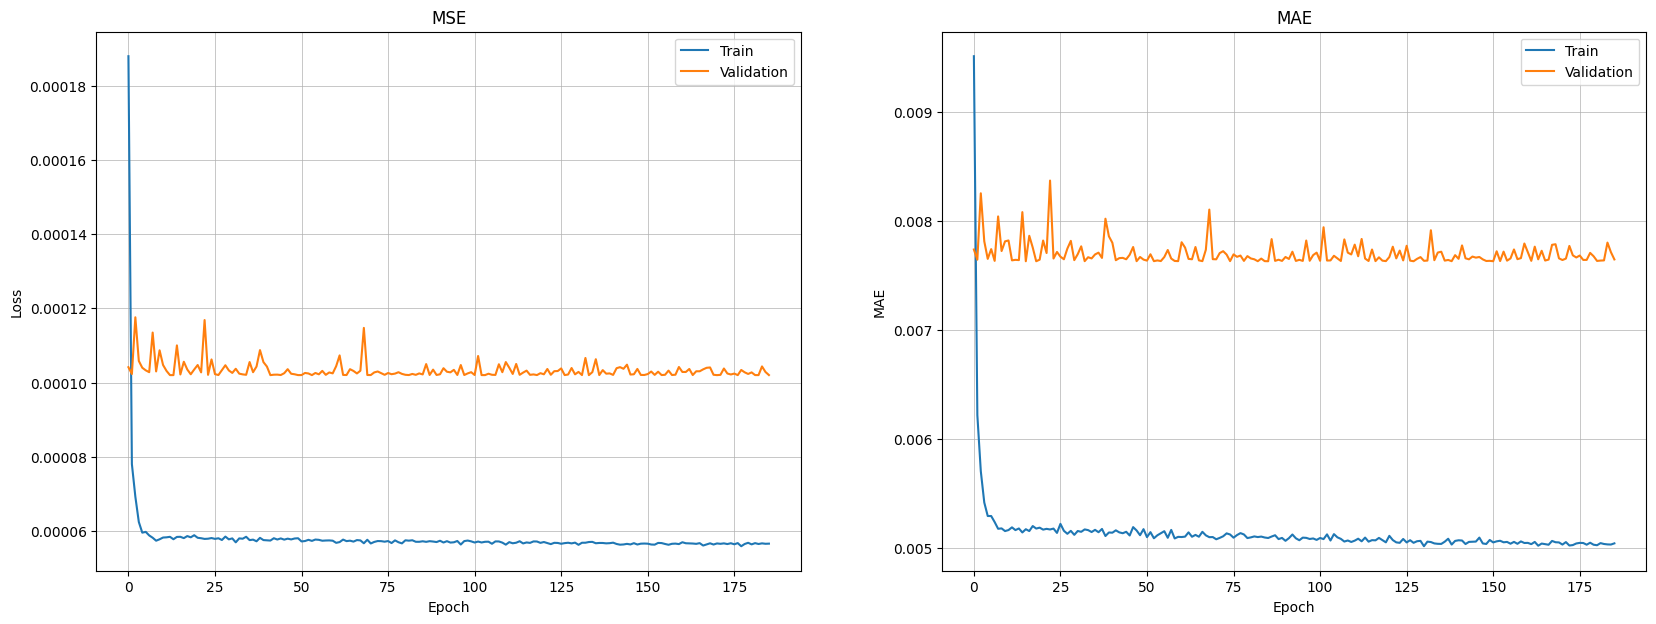

In [48]:
# Learning Curves:
plot_history(history)

In [ ]:
#Baseline MAE
0.0048812746058099115

# Learning Curves viz code:

In [47]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # Loss:MSE
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # Metrics:MAE
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax